# From Regression to Classification 

This notebook is based on Lecture 35: Classification and Lecture 36: Classifiers 

**Helpful Resource:**
- [Python Reference](http://data8.org/sp22/python-reference.html): Cheat sheet of helpful array & table methods used in Data 8!

**Recommended Readings**: 
- [Regression Inference](https://inferentialthinking.com/chapters/16/Inference_for_Regression.html)
- [Classifiers](https://inferentialthinking.com/chapters/17/Classification.html)
- [k-Nearest-Neighbor (kNN)](https://inferentialthinking.com/chapters/17/4/Implementing_the_Classifier.html)
- [Linear Discrimant Analysis (LDA)](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)


In [139]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np
from math import ceil
plots.rcParams.update({'font.size': 6})


### Regression Models as Classifiers

We'll combine two ideas from previous chapters: the least square regression model and the classifer. For the purpose of this discussion, we will limit ourselves to the problem of classifying whether a car is a sedan or not, based on 2 features from the ```cars``` data set. The idea is whether we can predict a vehicle is a sedan based on certain features from the data set. 

Text(0.5, 1.0, 'Whole Data Set with Original Labels')

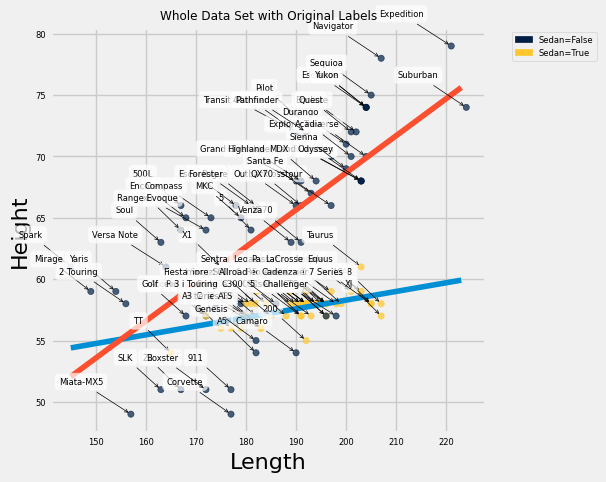

In [140]:
def standard_units(any_numbers):
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, xlabel, ylabel):
    return np.mean(standard_units(t.column(xlabel))*standard_units(t.column(ylabel)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

cars = Table().read_table('Cars2015.csv')

def is_sedan(car_type): 
    if car_type=="Sedan": 
        return True
    else:
        return False

sedan = cars.with_column("Sedan", cars.apply(is_sedan, 'Type'))
#cars.group('Type')
#feature1 = 'Length'
#feature2 = 'Weight'

feature1 = 'Length'
feature2 = 'Height'

sedan.scatter(feature1, feature2, group='Sedan', labels='Model')
def fit_two_lines(table, feature1, feature2):
    m_pos = slope(sedan.where('Sedan', True), feature1, feature2)
    b_pos = intercept(sedan.where('Sedan', True), feature1, feature2)
    m_neg = slope(sedan.where('Sedan', False), feature1, feature2)
    b_neg = intercept(sedan.where('Sedan', False), feature1, feature2)
    return m_pos, b_pos, m_neg, b_neg

m_pos, b_pos, m_neg, b_neg = fit_two_lines(sedan, feature1, feature2)
x_range = np.arange(min(sedan.column(feature1)), max(sedan.column(feature1)))
plots.plot(x_range, x_range*m_pos + b_pos, x_range, x_range*m_neg+ b_neg)
plots.title('Whole Data Set with Original Labels')


Here we first split the data randomly into training and test sets. Then we fit two regressional models to the training set, one for sedans and one for non-sedans. Then use these two regression models for classification. The model with the smallest absolute value of the residual wins. Instead of plotting the two regression models, we can plot the decision boundary of this classifier, which can be solved algebraically from the two regression lines. 

Training data size:  77 ; test data size 33
Error rate in training data 0.23376623376623376


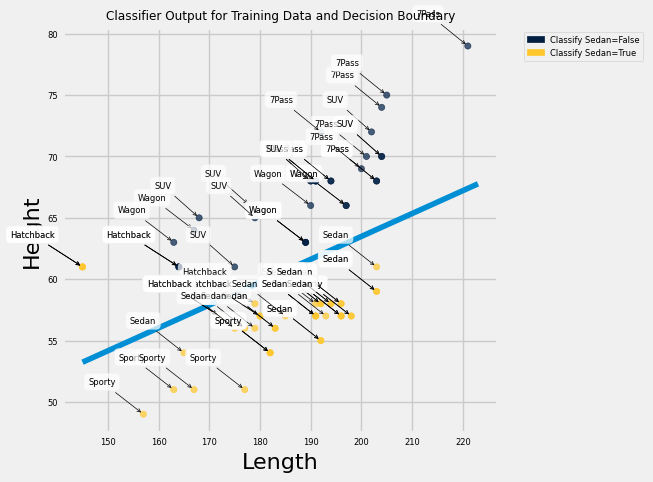

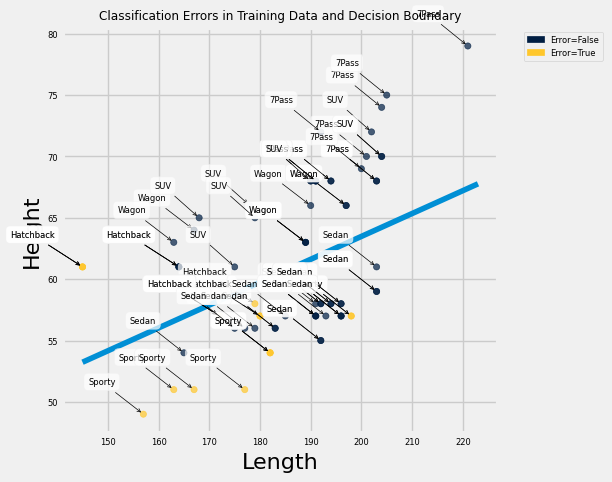

In [141]:
train_proportion = 0.7
# we randomly pick train_proportion to be the training data and the rest is test data
sedan_random = sedan.sample()
train_size = round(sedan.num_rows * train_proportion)
train_data = sedan_random.take(np.arange(train_size))
test_data = sedan_random.take(np.arange(train_size, sedan.num_rows))
print('Training data size: ', train_data.num_rows, "; test data size", test_data.num_rows)

m_pos, b_pos, m_neg, b_neg = fit_two_lines(train_data, feature1, feature2)

# the decision boundary is the line containing all points that have the same residual from the two regression lines
def decision_boundary(m1, b1, m2, b2):
    x0 = (b2-b1) / (m1-m2)
    y0 = m1*x0+b1
    x1 = 0
    y1 = (b1+b2)/2
    m = (y1-y0)/(x1-x0)
    b = y1
    return m, b

# classify the data table according to the two regression models, returns boolean array
def classify_table_LR(table, m_pos, b_pos, m_neg, b_neg):
    residual_pos = table.column(feature2) - (table.column(feature1)*m_pos + b_pos)
    residual_neg = table.column(feature2) - (table.column(feature1)*m_neg + b_neg)
    is_sedan = abs(residual_pos) < abs(residual_neg)
    return is_sedan

# evaluate the classifier and compare its output with the labels in the table 
def evaluate_classifier(table, m_pos, b_pos, m_neg, b_neg):
    is_sedan = classify_table_LR(table, m_pos, b_pos, m_neg, b_neg)
    table_with_output = table.with_column('Classify Sedan', classify_table_LR(table, m_pos, b_pos, m_neg, b_neg))
    is_error = (table_with_output.column('Sedan') != table_with_output.column('Classify Sedan'))
    return table_with_output.with_column('Error', is_error)
    
table_with_classification = evaluate_classifier(train_data, m_pos, b_pos, m_neg, b_neg)

table_with_classification.scatter(feature1, feature2, group='Classify Sedan', labels='Type')
m_boundary, b_boundary = decision_boundary(m_pos, b_pos, m_neg, b_neg)

#plots.plot(x_range, x_range*m_pos + b_pos, x_range, x_range*m_neg+ b_neg)
plots.plot(x_range, x_range*m_boundary+b_boundary)

plots.title('Classifier Output for Training Data and Decision Boundary')

table_with_classification.scatter(feature1, feature2, group='Error', labels='Type')
#plots.plot(x_range, x_range*m_pos + b_pos, x_range, x_range*m_neg+ b_neg)

plots.plot(x_range, x_range*m_boundary+b_boundary)
plots.title('Classification Errors in Training Data and Decision Boundary')

print("Error rate in training data", 
      np.count_nonzero(table_with_classification.column('Error')) / table_with_classification.num_rows)


It's not enough to evaluate the classifier on the training data. We should also observe its performance on the test data. 

Classification error rate in test data 0.18181818181818182


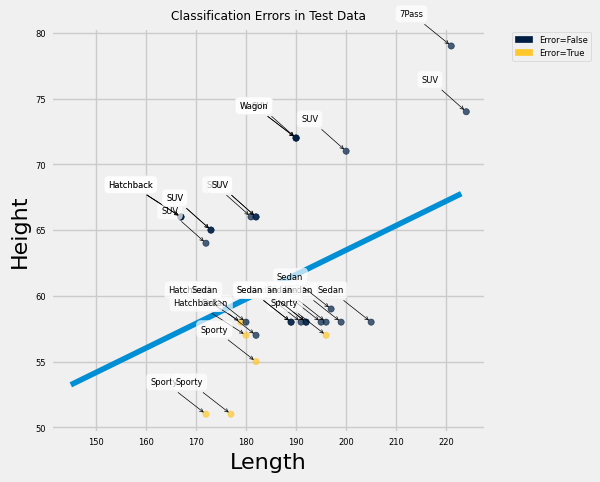

In [142]:
table_with_classification = evaluate_classifier(test_data, m_pos, b_pos, m_neg, b_neg)

table_with_classification.scatter(feature1, feature2, group='Error',labels='Type')
#plots.plot(x_range, x_range*m_pos + b_pos, x_range, x_range*m_neg+ b_neg)

plots.plot(x_range, x_range*m_boundary+b_boundary)

plots.title('Classification Errors in Test Data')

print("Classification error rate in test data", 
      np.count_nonzero(table_with_classification.column('Error')) / table_with_classification.num_rows)

### Non-parametric Classifier basd on k-Nearest Neighbors 

To compare with the regression-based "parametric" approach, which models the data with parameters (slope and intercept), we now build a non-parametric classifier based on the k-nearest neighbors. Here we only evaluate the classifier on the test set since the training set should perform close to 100% accuracy. 

In [143]:
# returns an array of distances from a row to each row in the table 
def distance_row_to_table(row, table, feature1, feature2):
    feature_vec = make_array(row.item(feature1), row.item(feature2))
    table_matrix = np.matrix([table.column(feature1), table.column(feature2)]).transpose()
    distance_matrix = np.tile(feature_vec, [table.num_rows, 1]) - table_matrix
    return np.squeeze(np.array(np.sqrt(np.square(distance_matrix).sum(1))))

# change this value to test varius cars in the test set to see whose their nearest neighbors 
# are in the training set 

test_index = 10
distances = distance_row_to_table(test_data.row(test_index), train_data, feature1, feature2)

train_data_with_distance = train_data.with_column('Distance', distances).move_column('Distance', 0)
print('Test item', test_data.take(test_index))
train_data_with_distance.sort('Distance')


Test item Make   | Model   | Type | LowPrice | HighPrice | Drive | CityMPG | HwyMPG | FuelCap | Length | Width | Wheelbase | Height | UTurn | Weight | Acc030 | Acc060 | QtrMile | PageNum | Size     | Sedan
Toyoto | 4Runner | SUV  | 33.21    | 43.62     | RWD   | 17      | 22     | 23      | 190    | 76    | 110       | 72     | 45    | 4665   | 3      | 7.7    | 16.1    | 209     | Midsized | False


Distance,Make,Model,Type,LowPrice,HighPrice,Drive,CityMPG,HwyMPG,FuelCap,Length,Width,Wheelbase,Height,UTurn,Weight,Acc030,Acc060,QtrMile,PageNum,Size,Sedan
2,Nissan,Pathfinder,7Pass,29.51,43.1,FWD,19,25,19.5,192,73,112,72,40,4505,3.2,7.7,16,193,Midsized,False
4,Jeep,Grand Cherokee,SUV,29.995,64.895,RWD,21,28,24.6,190,77,115,68,39,5365,3.1,8.6,16.7,159,Midsized,False
4,Jeep,Grand Cherokee,SUV,29.995,64.895,RWD,21,28,24.6,190,77,115,68,39,5365,3.1,8.6,16.7,159,Midsized,False
4.12311,Toyoto,Highlander,7Pass,29.665,50.24,FWD,18,24,19.2,191,76,110,68,40,4490,2.9,7.5,15.9,211,Midsized,False
4.12311,Toyoto,Highlander,7Pass,29.665,50.24,FWD,18,24,19.2,191,76,110,68,40,4490,2.9,7.5,15.9,211,Midsized,False
4.12311,Toyoto,Highlander,7Pass,29.665,50.24,FWD,18,24,19.2,191,76,110,68,40,4490,2.9,7.5,15.9,211,Midsized,False
5.65685,Acura,MDX,7Pass,42.865,57.08,FWD,18,27,19.5,194,77,111,68,40,4200,3,7.2,15.6,98,Midsized,False
5.65685,Acura,MDX,7Pass,42.865,57.08,FWD,18,27,19.5,194,77,111,68,40,4200,3,7.2,15.6,98,Midsized,False
6,Subaru,Outback,Wagon,24.895,32.995,AWD,25,33,18.5,190,72,108,66,39,3640,4.2,10.5,18.1,207,Midsized,False
9.05539,Toyoto,Venza,Wagon,29.065,39.94,FWD,18,25,17.7,189,75,109,63,42,4125,2.6,6.9,15.3,216,Midsized,False


In [144]:
K = 5 # an odd number
# perform classification with KNN. Take the majority rule

def classify_KNN(test_row, train_table, K, feature1, feature2):
    distances = distance_row_to_table(test_row, train_table, feature1, feature2)
    train_data_with_distance = train_table.with_column('Distance', distances).move_column('Distance', 0)
    sorted_table = train_data_with_distance.sort('Distance')
    knn_labels = sorted_table.take(np.arange(K)).column('Type')
    n_sedan = np.count_nonzero(knn_labels == 'Sedan')
    if n_sedan > round(K/2):
        return True
    else:
        return False
    
KNN_output = make_array()
for i in range(test_data.num_rows):
    is_sedan = classify_KNN(test_data.row(i), train_data, K, feature1, feature2)
    KNN_output = np.append(KNN_output, is_sedan)

test_data_with_KNN = test_data.with_column('KNN output', KNN_output).move_column('KNN output', 3)
errors = (test_data.column('Type') == 'Sedan') != test_data_with_KNN.column('KNN output')
test_data_with_errors_KNN = test_data_with_KNN.with_column("Error", errors).move_column('Error', 4)
print("Accuracy of KNN on test data: ", np.count_nonzero(errors) / test_data.num_rows)
print("Classification errors in the test set by KNN")
test_data_with_errors_KNN.where('Error', True)


Accuracy of KNN on test data:  0.12121212121212122
Classification errors in the test set by KNN


Make,Model,Type,KNN output,Error,LowPrice,HighPrice,Drive,CityMPG,HwyMPG,FuelCap,Length,Width,Wheelbase,Height,UTurn,Weight,Acc030,Acc060,QtrMile,PageNum,Size,Sedan
Volkswagon,Jetta,Sedan,0,True,16.215,31.12,FWD,25,36,14.5,182,70,104,57,37,3130,3.3,8.5,16.5,219,Small,True
Cadillac,CTS,Sporty,1,True,45.345,69.9,RWD,18,26,19,196,72,115,57,38,3915,2.7,6.8,15.2,115,Midsized,False
Subaru,Impreza,Sedan,0,True,18.195,23.295,AWD,27,36,14.5,180,69,104,58,38,3015,3.7,9.2,17.2,205,Small,True
Porche,911,Sporty,1,True,84.3,194.6,RWD,19,27,16.9,177,71,96,51,37,3235,1.6,4.1,12.4,198,Small,False


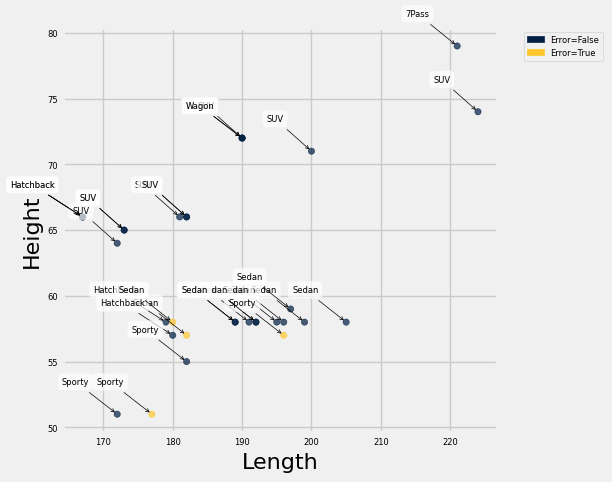

In [145]:
test_data_with_errors_KNN.scatter(feature1, feature2, group='Error',labels='Type')


### Linear Discriminant Analysis

As a third example of a parametric classifier that is based on linear models, we will consider the Linear Discriminant Analysis, which aims to maximize the separation of the positive and negative examples by projecting the data into a smaller space. In our example, since the original data live in a 2D space with two features, we seek to project the data onto a line (1D) and visualize the data in this reduced dimension through histograms. We start by projecting the data onto a linear similar to the decision boundary, which gives terrible separation between the two classes. 

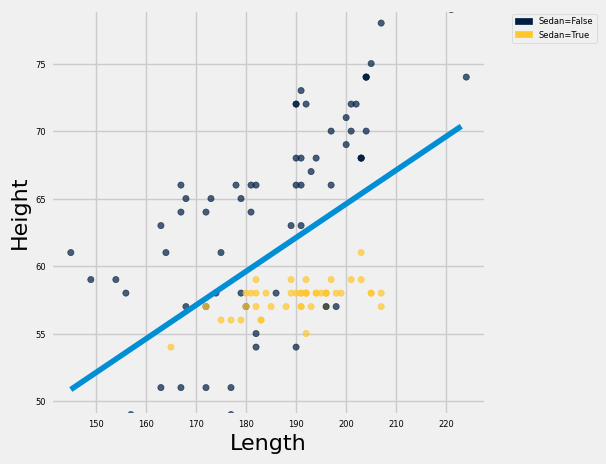

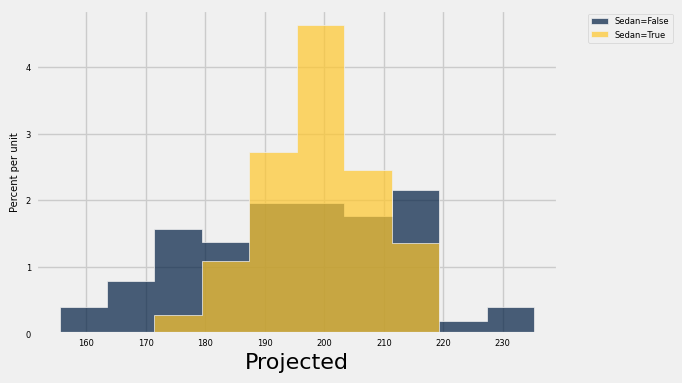

In [146]:
# project x vector onto another vector v, returns a scalar value 
def norm(v):
    return np.sqrt(np.square(v).sum())

def project(x_vec, v):
    return np.dot(x_vec, v) / norm(v)


# here we project the data in a table onto a vector 

def project_table_onto_v(v, table, feature1, feature2):
    projected_coord = make_array()
    for i in np.arange(table.num_rows):
         r = table.row(i)
         feature_vec = make_array(r.item(feature1), r.item(feature2))
         projected_coord = np.append(projected_coord, project(feature_vec, v))
    return projected_coord

# v can be any two-dimensional vector. To limit the number of solutions, we turn it into a unit vector 
v = make_array(4, 1)
v = v / norm(v)

sedan.scatter(feature1, feature2, group='Sedan')

# here we plot the line through the center that is parallel to the direction of projection. Notice this line can be shifted vertically
#  and it does not change the separation between classes 

center = np.average(sedan.column(feature1)), np.average(sedan.column(feature2))
plots.ylim(min(sedan.column(feature2)), max(sedan.column(feature2)))
plots.plot(x_range, (v[1]/v[0])*(x_range - center[0]) + center[1]) 

sedan.with_column('Projected', project_table_onto_v(v, sedan, feature1, feature2)).hist('Projected', group='Sedan')



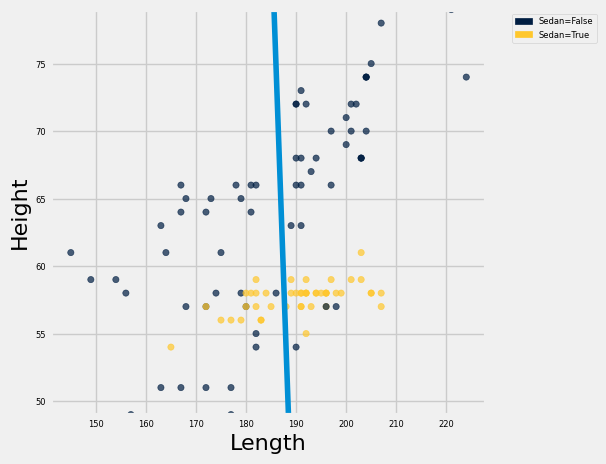

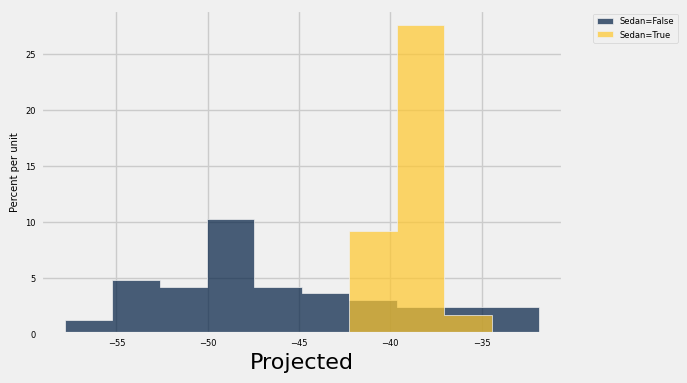

In [147]:
# we define the LDA loss function as -abs(mu1-mu2)/(sd1*sd2). So classes that are widely separated 
# will minimize this value. Since v is a unit vector, it can be parameterized by the angle theta

def LDA_loss(theta):
    v = make_array(np.cos(theta), np.sin(theta))
    sedan_with_projections = sedan.with_column('Projected', project_table_onto_v(v, sedan, feature1, feature2))
    pos = sedan_with_projections.where('Type', are.equal_to('Sedan')).column('Projected')
    neg = sedan_with_projections.where('Type', are.not_equal_to('Sedan')).column('Projected')
    m_pos, sd_pos = np.average(pos), np.std(pos)
    m_neg, sd_neg = np.average(neg), np.std(neg)
    return - abs(m_pos - m_neg) / (sd_pos*sd_neg)

# In standard LDA, the solution is found by solving eigenvalues of matrices. Here we use the numerical optimizer
# from the previous section on regression 

theta = minimize(LDA_loss)

v = make_array(np.cos(theta), np.sin(theta))

sedan.scatter(feature1, feature2, group='Sedan')

center = np.average(sedan.column(feature1)), np.average(sedan.column(feature2))
plots.ylim(min(sedan.column(feature2)), max(sedan.column(feature2)))
plots.plot(x_range, (v[1]/v[0])*(x_range - center[0]) + center[1]) 

sedan.with_column('Projected', project_table_onto_v(v, sedan, feature1, feature2)).hist('Projected', group='Sedan')


Finally, we can use the projection found by LDA to construct a classifier. A data point is projected using the same direction found in LDA, then we compare the z-score under each of the models. The model that produces the smallest absolute value of the z-score wins. This is equivalent to use two 2-dimensional Gaussian distributions to perform the classification. 

Accuracy of LDA classifier on test data:  0.8181818181818182


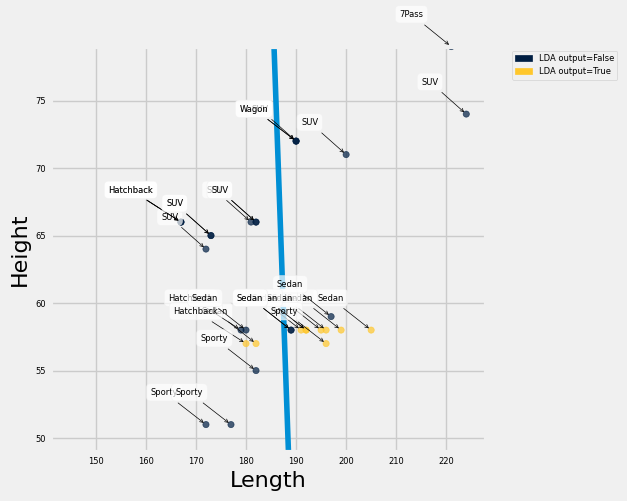

In [148]:
train_with_projections = train_data.with_column('Projected', project_table_onto_v(v, train_data, feature1, feature2))
pos = train_with_projections.where('Type', are.equal_to('Sedan')).column('Projected')
neg = train_with_projections.where('Type', are.not_equal_to('Sedan')).column('Projected')
m_pos, sd_pos = np.average(pos), np.std(pos)
m_neg, sd_neg = np.average(neg), np.std(neg)

def classify_LDA(table, v, feature1, feature2, m_pos, sd_pos, m_neg, sd_neg):
    projections = project_table_onto_v(v, table, feature1, feature2)
    z_pos = (projections - m_pos) / sd_pos
    z_neg = (projections - m_neg) / sd_neg
    return (abs(z_pos) < abs(z_neg))


LDA_classifer_output = classify_LDA(test_data, v, feature1, feature2, m_pos, sd_pos, m_neg, sd_neg)
test_data_with_LDA_output = test_data.with_column('LDA output', LDA_classifer_output).move_column('LDA output', 0)
test_data_with_LDA_output.scatter(feature1, feature2, group='LDA output', labels='Type')



center = np.average(sedan.column(feature1)), np.average(sedan.column(feature2))
plots.ylim(min(sedan.column(feature2)), max(sedan.column(feature2)))
plots.plot(x_range, (v[1]/v[0])*(x_range - center[0]) + center[1]) 

print('Accuracy of LDA classifier on test data: ', 
      np.count_nonzero(test_data_with_LDA_output.column('LDA output') == (test_data.column('Type') == 'Sedan')) / test_data.num_rows)

### Using the Multi-Layer Perceptron (neural network) as a classifier 

Here we use the popular package ```PyTorch``` to implement a neural network with a single hidden layer of a number of units. The split of training and test data is performed in the same way as above. 

In [149]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

features = np.array(np.asmatrix([sedan.column(feature1), sedan.column(feature2)]).T)
labels = sedan.column('Sedan')

class LoadDataset(Dataset):
    def __init__(self, features, labels):
        """
        Args:
            features (array-like): 2D array of shape (num_samples, num_features)
            labels (array-like): 1D array of shape (num_samples,)
        """
        self.features = np.asarray(features, dtype=np.float32)
        self.labels = np.asarray(labels, dtype=np.int64)
        
        # Verify input dimensions
        if len(self.features) != len(self.labels):
            print(len(self.features), len(self.labels))
            raise ValueError("Features and labels must have the same number of samples")
            
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'features': torch.from_numpy(self.features[idx]),
            'label': torch.tensor(self.labels[idx])
        }

# Create dataset from separate features and labels
dataset = LoadDataset(features, labels)
input_size = dataset.features.shape[1]
num_classes = len(np.unique(dataset.labels))
dataset.labels

# Split dataset into train and test (remainder of code unchanged)
dataset_size = len(dataset)
test_size = int((1-train_proportion) * dataset_size)
train_size = dataset_size - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Here we train a Multi-Layer Perceptron with a hidden layer. 

In [201]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.ReLU(),
            nn.Tanh(),
            nn.Linear(hidden_size, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

# Hyperparameters
hidden_size = 32
batch_size = 1
learning_rate = 0.0001
num_epochs = 20

In [202]:

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        fea = batch['features'].to(device)
        lab = batch['label'].to(device)
        
        outputs = model(fea)
        loss = criterion(outputs, lab)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        fea = batch['features'].to(device)
        lab = batch['label'].to(device)
        
        outputs = model(fea)
        _, predicted = torch.max(outputs.data, 1)
        total += lab.size(0)
        correct += (predicted == lab).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/20], Loss: 0.6205
Epoch [2/20], Loss: 0.7278
Epoch [3/20], Loss: 0.7381
Epoch [4/20], Loss: 0.5957
Epoch [5/20], Loss: 0.7374
Epoch [6/20], Loss: 0.7160
Epoch [7/20], Loss: 0.7033
Epoch [8/20], Loss: 0.7228
Epoch [9/20], Loss: 0.7335
Epoch [10/20], Loss: 0.6157
Epoch [11/20], Loss: 0.6126
Epoch [12/20], Loss: 0.6109
Epoch [13/20], Loss: 0.6055
Epoch [14/20], Loss: 0.6021
Epoch [15/20], Loss: 0.5804
Epoch [16/20], Loss: 0.3651
Epoch [17/20], Loss: 0.5854
Epoch [18/20], Loss: 0.4477
Epoch [19/20], Loss: 0.3398
Epoch [20/20], Loss: 0.4612
Test Accuracy: 84.85%


In [203]:
model.layers

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=2, bias=True)
)

We can examine the decision bounary of the MLP below. 

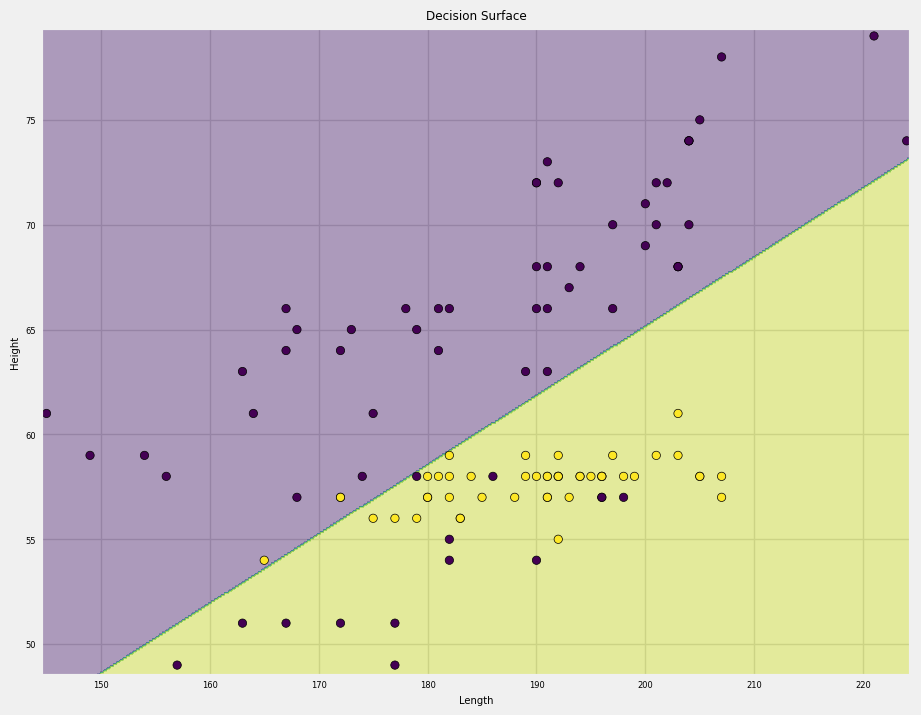

In [198]:
# 4. Create mesh grid for decision surface
def plot_decision_surface(model, X, y):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Make predictions
    mesh_data = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    with torch.no_grad():
        outputs = model(torch.from_numpy(mesh_data).to(device))
        _, predicted = torch.max(outputs, 1)
        Z = predicted.numpy().reshape(xx.shape)
    
    # Plot
    plots.figure(figsize=(10, 8))
    plots.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')

    plots.scatter(X[:, 0], X[:, 1], c=labels, edgecolor='k', cmap='viridis')
    plots.title("Decision Surface")
    plots.xlabel(feature1)
    plots.ylabel(feature2)
    plots.show()

# 5. Plot the decision surface
plot_decision_surface(model, features, labels)

In [181]:
a = torch.rand(4, 2)
_, pred = torch.max(a, 1)
a, pred

(tensor([[0.7901, 0.6106],
         [0.3550, 0.9908],
         [0.4588, 0.1002],
         [0.9258, 0.0753]]),
 tensor([0, 1, 0, 0]))